# MCMC of truncated data: $<\lambda | \mu_{\star}>$

In [1]:
import lmc
import lrgs
import lrgs.trunc
import numpy as np
import scipy.stats as st
import scipy.integrate
import matplotlib.pyplot as plt

from mpi4py import MPI
world = MPI.COMM_WORLD
mpi_rank = world.Get_rank()

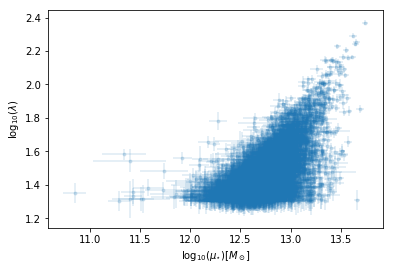

In [2]:
#Loading the data: x=log10(mustar), y=log10(lambda)
x, xerr, y ,yerr = np.loadtxt("./y1_mustar_lambda.txt", unpack=True)

#Plotting the data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x, y, xerr=xerr, yerr=yerr, marker='.', ls=' ', alpha=0.15)
ax.set_ylabel(r'$\log_{10}(\lambda)$')
ax.set_xlabel(r'$\log_{10}(\mu_{\star}) [M_\odot]$')
plt.show()

In [3]:
#Changing format for LRGs
x = np.matrix(x)#.T
y = np.matrix(y)#.T

M = []
for i in range(len(yerr)):
    e = np.asmatrix(np.eye(2))
    e[0,0]*=xerr[i]
    e[1,1]*=yerr[i]
    M.append(e)

In [4]:
## Truncation on $\hat{y}$

ylim = 1.3 #equivalent to lamda>20
det = np.where(y[:,0] > ylim)[0]

data_try = {'N': len(det),
            'M': [M[i] for i in det],
            'x': x[det,:],
            'y': y[det,:]
           }


In [5]:
par = lrgs.Parameters_ExpMix(1, data_try['x'], data_try['y'], M=data_try['M'])

/Users/maria/anaconda2/lib/python2.7/site-packages/lrgs/lrgs.py:87: RuntimeWarning: divide by zero encountered in divide
  self.Sigma_inv = np.matrix(np.diag(1.0/np.diag(self.Sigma)))


In [6]:
def dfdet_dx(x, lam=2.0, ylim=1.3, alpha=0, beta=1, s2=0.16, m2=0.05**2):
    
    return st.expon.pdf(x, scale=1.0/lam) * (1.0 - st.norm.cdf( (ylim-alpha-beta*x)/np.sqrt(s2+m2) ))

def calc_fdet(s):
    
    return scipy.integrate.quad(dfdet_dx, 0.0, 10.0, args=(s.rate[0][0](), ylim, s.B[0][0](), s.B[1][0](), s.Sigma[0][0](), data_try['M'][0][1,1]))[0]


def extrapriors(s):
    lam = s.rate[0][0]()
    if lam <= 0.0:
        return -np.inf
    return st.norm.logpdf(lam, 2.0, 0.05)


In [7]:
trunc = lrgs.trunc.PoissonTruncated_ExpMix(par, calc_fdet, extra_priors=extrapriors, parallel=world)

MemoryError: 

In [ ]:
chainfile = open("Lambda_Mu_TruncYMPI_" + str(mpi_rank) + ".txt", 'w')
chainfile.write(' '.join([p.name for p in trunc.trace]) + '\n')
backends = [ lmc.textBackend(chainfile, flush=True) ]

In [ ]:
trunc.run(1000, backends)